1) original + community overwrite: 전체 그래프에 대해 GRL을 수행한 후 Major community(threshold를 만족하는 community)에 대해서 Local GRL으로 overwrite 하는 방법

=> 정확도 최대, 병렬처리 불가 (처리속도 최하)
* 처리속도 = 전체 그래프 GRL + Major Community Local GRL 수행 시간 측정

In [1]:
import pandas as pd
import numpy as np
from igraph import Graph
import igraph
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter,BiasedRandomWalk,UnsupervisedSampler,UniformRandomWalk
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from tensorflow import keras
import multiprocessing as mp
import pickle
import time
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [2]:
# Edge between two user node (607,333 friendships)
file = '/home/jhpark/dataset_WWW2019/dataset_WWW2019/dataset_WWW_friendship_new.txt'
g = nx.read_edgelist(file , nodetype = int, edgetype='Freindship')

In [3]:
ig = Graph.from_networkx(g) # NetworkX to igraph 
ig.vs["id"] = ig.vs["_nx_name"]
ig.es["weight"] = [1.0]*ig.ecount()

In [4]:
node_features_encoded = pd.read_csv("/home/jhpark/dataset_WWW2019/node_features_encoded.csv", index_col=0)
country_degree = pd.concat([node_features_encoded['countrycode_encoded'], node_features_encoded['degree']],axis=1)

In [5]:
userGraph_country_deg = StellarGraph.from_networkx(ig.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = country_degree)
print(userGraph_country_deg.info())

StellarGraph: Undirected multigraph
 Nodes: 114324, Edges: 607333

 Node types:
  user: [114324]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [607333]
        Weights: all 1 (default)
        Features: none


In [6]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(userGraph_country_deg)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 60733 positive and 60733 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 114324, Edges: 546600

 Node types:
  user: [114324]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [546600]
        Weights: all 1 (default)
        Features: none


In [7]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, userGraph_country_deg)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 54660 positive and 54660 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 114324, Edges: 491940

 Node types:
  user: [114324]
    Features: float32 vector, length 2
    Edge types: user-friendship->user

 Edge types:
    user-friendship->user: [491940]
        Weights: all 1 (default)
        Features: none


In [8]:
pd.DataFrame(
    [
        (  "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (   "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (   "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,81990,Train Graph,Test Graph,Train the Link Classifier
Model Selection,27330,Train Graph,Test Graph,Select the best Link Classifier model
Test set,121466,Test Graph,Full Graph,Evaluate the best Link Classifier


In [10]:
# Node2Vec Hyper-parameter Settings
p = 1.0 # p가 낮을 수록 좁은 지역을 보고 q가 낮을수록 넓은 지역을 봅니다.
q = 1.0
dimensions = 256
num_walks = 10
walk_length = 80
window_size = 10
num_iter = 1
workers = mp.cpu_count()

In [11]:
def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size =dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

#    def get_embedding(u):
#        return model.wv[u]

#    return get_embedding
    return model.wv

In [12]:
start = time.time()
embedding_train = node2vec_embedding(graph_train, "Train Graph")
print(len(embedding_train))
originalGRL_time = time.time() - start
print("@@@ 전체 그래프 GRL time :", originalGRL_time," @@@")

Number of random walks for 'Train Graph': 1143240
114324
@@@ 전체 그래프 GRL time : 7042.073302745819  @@@


In [13]:
# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node[src], transform_node[dst])
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

In [14]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator,embedding_train):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {
        "classifier": clf,
        "binary_operator": binary_operator,
        "score": score,
    }


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [15]:
results = [run_link_prediction(op,embedding_train) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_hadamard'


,ROC AUC score
name,
operator_hadamard,0.981123
operator_l1,0.959906
operator_l2,0.961016
operator_avg,0.734832


In [16]:
start = time.time()
embedding_test = node2vec_embedding(graph_test, "Test Graph")
print("@@@ 전체 그래프 GRL time for test set:", time.time() - start," @@@")

Number of random walks for 'Test Graph': 1143240
@@@ 전체 그래프 GRL time for test set: 7319.544372797012  @@@


In [17]:
for result in results:
    test_score = evaluate_link_prediction_model(
        result["classifier"],
        examples_test,
        labels_test,
        embedding_test,
        result["binary_operator"],
    )
    print(
        f"ROC AUC score on test set using '{result['binary_operator'].__name__}': {test_score}"
    )

ROC AUC score on test set using 'operator_hadamard': 0.920812379103256
ROC AUC score on test set using 'operator_l1': 0.9017978177508157
ROC AUC score on test set using 'operator_l2': 0.8810290512321426
ROC AUC score on test set using 'operator_avg': 0.5064495163303888


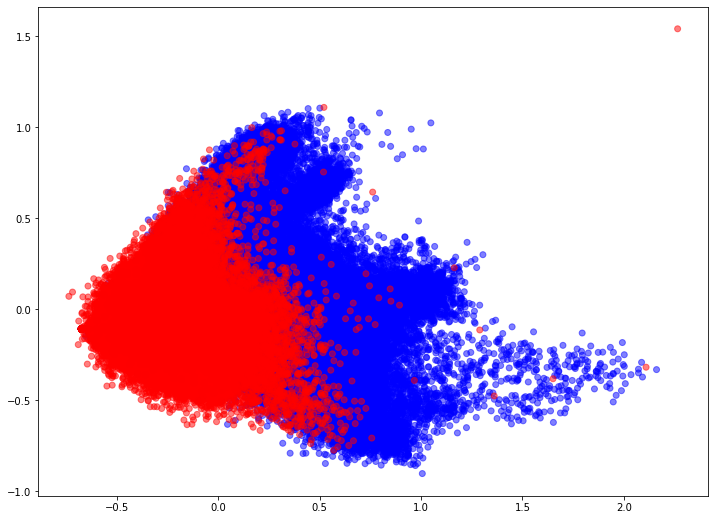

In [18]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(12, 9))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

### Major community (threshold를 만족하는 community)에 대해서 Local GRL

In [19]:
with open("/home/jhpark/dataset_WWW2019/community_info.pickle","rb") as f:
    LP = pickle.load(f)

In [20]:
def sub_Node2Vec(subgraphList,name):
    subgraph = ig.induced_subgraph(subgraphList,implementation="create_from_scratch")
    isin_filter = node_features_encoded['userID'].isin(subgraph.vs['id'])
    
    subgraph_features = node_features_encoded[isin_filter]
    subgraph_country_degree = pd.concat([subgraph_features['countrycode_encoded'], subgraph_features['degree']],axis=1)
    subgraph_country_degree.reset_index(drop=True,inplace=True)
    
    subgraph_ = StellarGraph.from_networkx(subgraph.to_networkx(), node_type_default = "user", edge_type_default = "friendship", node_features = subgraph_country_degree)
    
  #  print(subgraph_.info())
    
    #########################################################################
    rw = BiasedRandomWalk(subgraph_)
    walks = rw.run(subgraph_.nodes(), n=num_walks, length=walk_length, p=p, q=q)
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size =dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=workers,
        epochs=num_iter,
    )

    return model.wv

In [21]:
node_embeddings = embedding_train

In [22]:
start = time.time()
for community_idx in range(len(LP)):
    # Intra Community Embedding 
    if len(LP[community_idx]) > 100:
        sub_node_embeddings = sub_Node2Vec(LP[community_idx],"Sub-graph no.["+str(community_idx)+"]")
        print(len(sub_node_embeddings))
        
        # 전체 그래프에 대한 GraphSAGE에 의해 도출된 feature를 아예 덮어쓰는 것. 
        j = 0
        for i in LP[community_idx]:
          #  print(i, end=' ')
            node_embeddings[i] = sub_node_embeddings[j]
            j+=1 
localGRL_time = time.time() - start
print("@@@ Major Community Local GRL time :", localGRL_time ," @@@")

Number of random walks for 'Sub-graph no.[0]': 144970
14497
Number of random walks for 'Sub-graph no.[2]': 2410
241
Number of random walks for 'Sub-graph no.[3]': 21800
2180
Number of random walks for 'Sub-graph no.[5]': 9560
956
Number of random walks for 'Sub-graph no.[9]': 17670
1767
Number of random walks for 'Sub-graph no.[10]': 45210
4521
Number of random walks for 'Sub-graph no.[13]': 1910
191
Number of random walks for 'Sub-graph no.[14]': 1030
103
Number of random walks for 'Sub-graph no.[15]': 1020
102
Number of random walks for 'Sub-graph no.[16]': 74680
7468
Number of random walks for 'Sub-graph no.[17]': 63050
6305
Number of random walks for 'Sub-graph no.[18]': 114160
11416
Number of random walks for 'Sub-graph no.[19]': 8050
805
Number of random walks for 'Sub-graph no.[20]': 1190
119
Number of random walks for 'Sub-graph no.[22]': 7060
706
Number of random walks for 'Sub-graph no.[23]': 2460
246
Number of random walks for 'Sub-graph no.[24]': 4430
443
Number of random w

In [23]:
start = time.time()
results = [run_link_prediction(op, node_embeddings) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")
print("time :", time.time() - start)

Best result from 'operator_hadamard'
time : 120.04184007644653


In [24]:
start = time.time()

embedding_test = node2vec_embedding(graph_test, "Test Graph")

for result in results:
    test_score = evaluate_link_prediction_model(
        result["classifier"],
        examples_test,
        labels_test,
        node_embeddings,
        result["binary_operator"],
    )
    print(
        f"ROC AUC score on test set using '{result['binary_operator'].__name__}': {test_score}"
    )
print("time :", time.time() - start)

Number of random walks for 'Test Graph': 1143240
ROC AUC score on test set using 'operator_hadamard': 0.9385227630026327
ROC AUC score on test set using 'operator_l1': 0.9197403850931771
ROC AUC score on test set using 'operator_l2': 0.9192392042991685
ROC AUC score on test set using 'operator_avg': 0.7105292859549666
time : 7330.741523981094


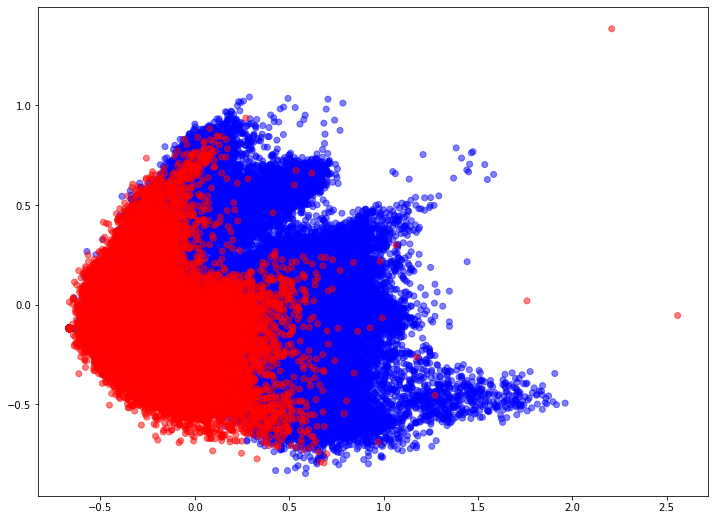

In [25]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(12, 9))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

In [26]:
print("Total Time: ", originalGRL_time + localGRL_time)

Total Time:  14345.570031404495
